/tmp/ipykernel_1331667/2832828374.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features].fillna(0, inplace=True)


Epoch [1/500], Loss: 0.0686
Epoch [2/500], Loss: 0.0615
Epoch [3/500], Loss: 0.0509
Epoch [4/500], Loss: 0.0438
Epoch [5/500], Loss: 0.0360
Epoch [6/500], Loss: 0.0329
Epoch [7/500], Loss: 0.0326
Epoch [8/500], Loss: 0.0303
Epoch [9/500], Loss: 0.0294
Epoch [10/500], Loss: 0.0316
Epoch [11/500], Loss: 0.0304
Epoch [12/500], Loss: 0.0294
Epoch [13/500], Loss: 0.0304
Epoch [14/500], Loss: 0.0294
Epoch [15/500], Loss: 0.0300
Epoch [16/500], Loss: 0.0291
Epoch [17/500], Loss: 0.0287
Epoch [18/500], Loss: 0.0289
Epoch [19/500], Loss: 0.0286
Epoch [20/500], Loss: 0.0287
Epoch [21/500], Loss: 0.0283
Epoch [22/500], Loss: 0.0276
Epoch [23/500], Loss: 0.0266
Epoch [24/500], Loss: 0.0266
Epoch [25/500], Loss: 0.0257
Epoch [26/500], Loss: 0.0257
Epoch [27/500], Loss: 0.0246
Epoch [28/500], Loss: 0.0241
Epoch [29/500], Loss: 0.0238
Epoch [30/500], Loss: 0.0236
Epoch [31/500], Loss: 0.0233
Epoch [32/500], Loss: 0.0233
Epoch [33/500], Loss: 0.0227
Epoch [34/500], Loss: 0.0222
Epoch [35/500], Loss: 0

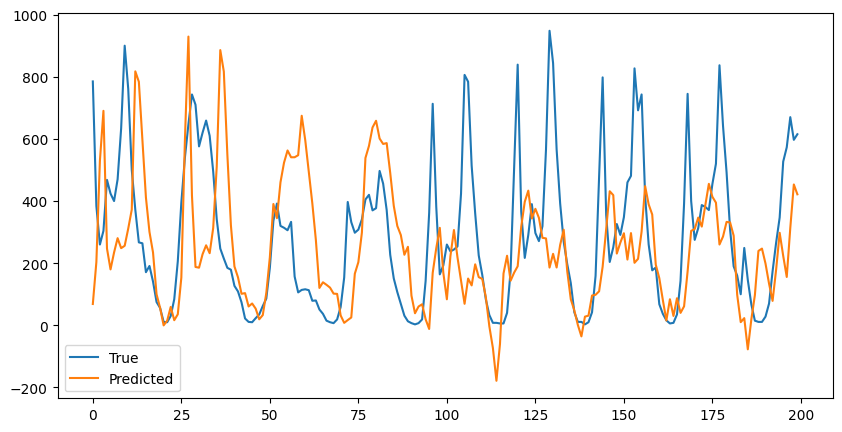

In [6]:
# -*- coding: utf-8 -*-
"""
LSTM模型用于共享单车租赁预测
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# 解决画图中文显示问题
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

# 参数设置
look_back = 96  # 输入的历史时间步
epochs = 500  # 迭代次数
batch_size = 64  # 批量大小
input_dim = 9  # 输入特征数
hidden_dim = 64  # 隐藏层神经元数
num_layers = 2  # LSTM层数
dropout = 0.2  # Dropout
learn_rate = 0.0005  # 学习率

# 加载数据
# train_data = pd.read_csv('train_data.csv')
# test_data = pd.read_csv('test_data.csv')

data_path = r'../data/'
train_data = pd.read_csv(data_path + 'train_data.csv')
test_data = pd.read_csv(data_path + 'test_data.csv')

# 选择特征和目标列
# features = ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
features = [  'temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

train_data[features].fillna(0, inplace=True)
train_data[target].fillna(0, inplace=True)


# 数据预处理：归一化
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

train_data[features] = scaler_features.fit_transform(train_data[features])
train_data[target] = scaler_target.fit_transform(train_data[[target]])
test_data[features] = scaler_features.transform(test_data[features])
test_data[target] = scaler_target.transform(test_data[[target]])

train_data[features] = train_data[features].fillna(train_data[features].mean())
test_data[features] = test_data[features].fillna(test_data[features].mean())

features = ['season', 'cnt', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


# 构建时间序列数据
def create_sequences(data, features, target, look_back):
    X, y = [], []
    for i in range(0, len(data) - 2 * look_back, 96):
        X.append(data[features].iloc[i:i + look_back].values)
        y.append(data[target].iloc[i + look_back:i + 2 * look_back].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, features, target, look_back)
X_test, y_test = create_sequences(test_data, features, target, look_back)

# 转换为 PyTorch Tensor 
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)#.unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)#.unsqueeze(1)

# 数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, output_dim*2)
        self.fc2 = nn.Linear(output_dim*2, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)  # 取最后时间步的输出
        return out

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=96, num_layers=num_layers, dropout=dropout)
model = model.to(device)

# 初始化权重
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

model.apply(init_weights)

# 损失函数与优化器
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learn_rate)

# 梯度裁剪
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# 训练
train_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        if torch.isnan(loss):
            raise ValueError("Loss became NaN during training.")
        
        loss.backward()
        clip_gradients(model)
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

# 测试
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

# 反归一化
predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

# predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
# actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

# 评估
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# 可视化结果
plt.figure(figsize=(10, 5))
plt.plot(actuals[:200], label="True")
plt.plot(predictions[:200], label="Predicted")
plt.legend()
plt.show()


MSE: 0.0026, MAE: 0.0319


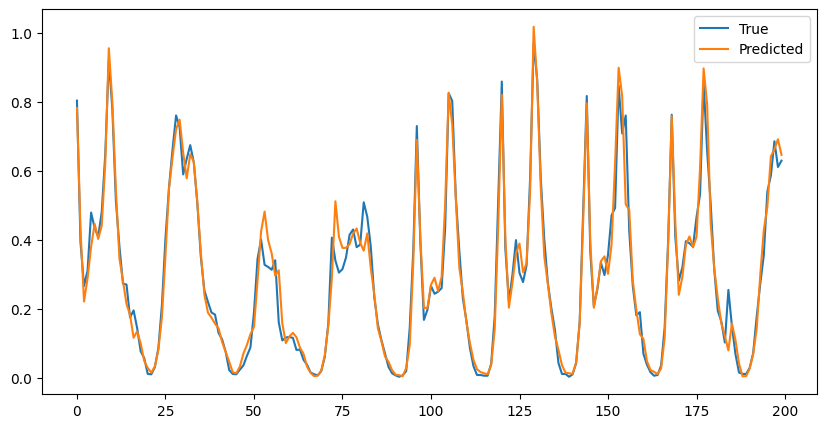

In [3]:
predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

# 评估
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# 可视化结果
plt.figure(figsize=(10, 5))
plt.plot(actuals[:200], label="True")
plt.plot(predictions[:200], label="Predicted")
plt.legend()
plt.show()


In [30]:
predictions

array([[0.7656751 ],
       [0.41256487],
       [0.2476413 ],
       ...,
       [0.07559608],
       [0.07412482],
       [0.0532172 ]], dtype=float32)

In [14]:
print("Check NaN in Train Features:", train_data[features].isnull().sum())
print("Check NaN in Train Target:", train_data[target].isnull().sum())
print("Check Min/Max of Train Features:", train_data[features].min().min(), train_data[features].max().max())
print("Check Min/Max of Train Target:", train_data[target].min(), train_data[target].max())


Check NaN in Train Features: season        0
yr            0
holiday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64
Check NaN in Train Target: 0
Check Min/Max of Train Features: 0.0 1.0
Check Min/Max of Train Target: 0.0 1.0


In [28]:
# -*- coding: utf-8 -*-
"""
LSTM模型用于共享单车租赁预测
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# 解决画图中文显示问题
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

# 参数设置
look_back = 96  # 输入的历史时间步
epochs = 500  # 迭代次数
batch_size = 64  # 批量大小
input_dim = 10  # 输入特征数
hidden_dim = 64  # 隐藏层神经元数
num_layers = 2  # LSTM层数
dropout = 0.2  # Dropout
learn_rate = 0.0005  # 学习率

# 加载数据
# train_data = pd.read_csv('train_data.csv')
# test_data = pd.read_csv('test_data.csv')

data_path = r'../data/'
train_data = pd.read_csv(data_path + 'train_data.csv')
test_data = pd.read_csv(data_path + 'test_data.csv')

# 选择特征和目标列
features = ['holiday','cnt']
# features = ['season', 'yr', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

# features = ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

target = 'cnt'

input_dim = len(features)  # 输入特征数

train_data[features].fillna(0, inplace=True)
train_data[target].fillna(0, inplace=True)


# 数据预处理：归一化
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

train_data[features] = scaler_features.fit_transform(train_data[features])
train_data[target] = scaler_target.fit_transform(train_data[[target]])
test_data[features] = scaler_features.transform(test_data[features])
test_data[target] = scaler_target.transform(test_data[[target]])

train_data[features] = train_data[features].fillna(train_data[features].mean())
test_data[features] = test_data[features].fillna(test_data[features].mean())


# 构建时间序列数据
def create_sequences(data, features, target, look_back):
    X, y = [], []
    for i in range(0, len(data) - 2 * look_back, 96):
        X.append(data[features].iloc[i:i + look_back].values)
        y.append(data[target].iloc[i + look_back:i + 2 * look_back].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, features, target, look_back)
X_test, y_test = create_sequences(test_data, features, target, look_back)

# 转换为 PyTorch Tensor 
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)#.unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)#.unsqueeze(1)

# 数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 取最后时间步的输出
        return out

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=96, num_layers=num_layers, dropout=dropout)
model = model.to(device)

# 初始化权重
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

model.apply(init_weights)

# 损失函数与优化器
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learn_rate)

# 梯度裁剪
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# 训练
train_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        if torch.isnan(loss):
            raise ValueError("Loss became NaN during training.")
        
        loss.backward()
        clip_gradients(model)
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

# 测试
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())


/tmp/ipykernel_1299105/824652042.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features].fillna(0, inplace=True)


Epoch [1/500], Loss: 0.0778
Epoch [2/500], Loss: 0.0765
Epoch [3/500], Loss: 0.0748
Epoch [4/500], Loss: 0.0728
Epoch [5/500], Loss: 0.0722
Epoch [6/500], Loss: 0.0693
Epoch [7/500], Loss: 0.0659
Epoch [8/500], Loss: 0.0625
Epoch [9/500], Loss: 0.0559
Epoch [10/500], Loss: 0.0459
Epoch [11/500], Loss: 0.0372
Epoch [12/500], Loss: 0.0379
Epoch [13/500], Loss: 0.0318
Epoch [14/500], Loss: 0.0322
Epoch [15/500], Loss: 0.0305
Epoch [16/500], Loss: 0.0297
Epoch [17/500], Loss: 0.0297
Epoch [18/500], Loss: 0.0296
Epoch [19/500], Loss: 0.0293
Epoch [20/500], Loss: 0.0280
Epoch [21/500], Loss: 0.0281
Epoch [22/500], Loss: 0.0272
Epoch [23/500], Loss: 0.0273
Epoch [24/500], Loss: 0.0268
Epoch [25/500], Loss: 0.0257
Epoch [26/500], Loss: 0.0261
Epoch [27/500], Loss: 0.0255
Epoch [28/500], Loss: 0.0244
Epoch [29/500], Loss: 0.0241
Epoch [30/500], Loss: 0.0249
Epoch [31/500], Loss: 0.0245
Epoch [32/500], Loss: 0.0243
Epoch [33/500], Loss: 0.0245
Epoch [34/500], Loss: 0.0241
Epoch [35/500], Loss: 0